<a href="https://colab.research.google.com/github/mobadata/detection-nouveautes-avis/blob/main/Detection_nouveautes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importons les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("punkt")
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Montons note Google drive dans le notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Importation des données

# Chemin du fichier JSON dans le drive
chemin_fichier = "/content/drive/MyDrive/mon_projet_nouveautes/Electronics_5.json"

# Chargement du fichier (format JSON lignes si Amazon)
df = pd.read_json(chemin_fichier, lines=True)

# Affichage des premières lignes
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [6]:

# infos sur les variables
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


In [7]:
# Apercu statistique des données
df.describe(include='all')


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
count,1689188,1689188,1664458,1689188,1689188,1.689188e+06,1689188,1.689188e+06,1689188
unique,192403,63001,162859,8331,1687169,NaN,1139738,NaN,5277
top,ADLVFFE4VBT8,B007WTAJTO,Amazon Customer,"[0, 0]",,NaN,Works great,NaN,"01 7, 2014"
freq,431,4915,26961,963227,1071,NaN,6784,NaN,3051
mean,NaN,NaN,NaN,NaN,NaN,4.222779e+00,NaN,1.340571e+09,NaN
std,NaN,NaN,NaN,NaN,NaN,1.185632e+00,NaN,6.342451e+07,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,9.292320e+08,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,1.318118e+09,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.360800e+09,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.385078e+09,NaN


In [ ]:
# Visualisons les avis
df["reviewText"].head(10)


,reviewText
0,We got this GPS for my husband who is an (OTR)...
1,"I'm a professional OTR truck driver, and I bou..."
2,"Well, what can I say. I've had this unit in m..."
3,"Not going to write a long review, even thought..."
4,I've had mine for a year and here's what we go...
5,I am using this with a Nook HD+. It works as d...
6,The cable is very wobbly and sometimes disconn...
7,This adaptor is real easy to setup and use rig...
8,This adapter easily connects my Nook HD 7&#34;...
9,This product really works great but I found th...


In [8]:
# Nettoyage des données
stop_words = set(stopwords.words('english'))

def nettoyer_texte(texte):
    if isinstance(texte, str):
        texte = texte.lower()  # Met en minuscule
        texte = re.sub(r"[^a-z\s]", "", texte)  # Supprime les caractères non alphabétiques
        tokens = word_tokenize(texte)  # Tokenisation
        mots_utiles = [mot for mot in tokens if mot not in stop_words]  # Supprime les stopwords
        return " ".join(mots_utiles)
    else:
        return ""

In [ ]:
# On applique la fonction sur la variable reviewText
df["review_clean"] = df["reviewText"].apply(nettoyer_texte)
df[["reviewText", "review_clean"]].head()

,reviewText,review_clean
0,We got this GPS for my husband who is an (OTR)...,got gps husband otr road trucker impressed shi...
1,"I'm a professional OTR truck driver, and I bou...",im professional otr truck driver bought tnd tr...
2,"Well, what can I say. I've had this unit in m...",well say ive unit truck four days prior garmin...
3,"Not going to write a long review, even thought...",going write long review even thought unit dese...
4,I've had mine for a year and here's what we go...,ive mine year heres got tries route non truck ...


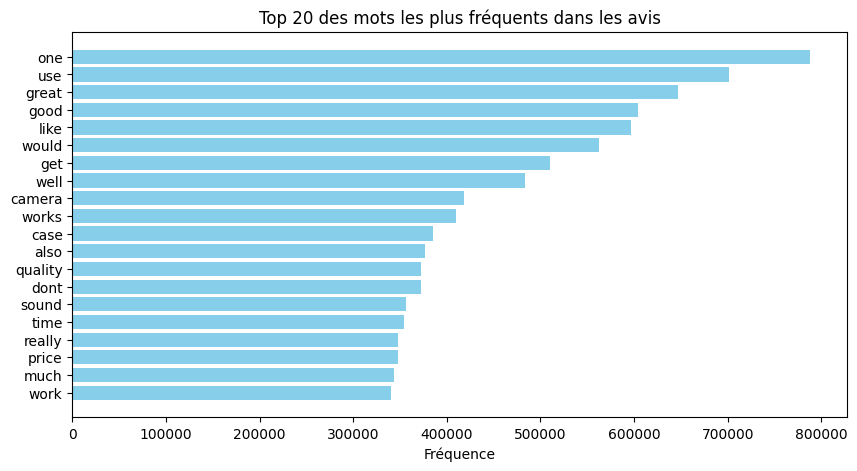

In [ ]:

# Récupérer tous les mots des textes nettoyés
tous_les_mots = " ".join(df["review_clean"]).split()

# Compter la fréquence des mots
freq = Counter(tous_les_mots)

# Top 20
top_mots = freq.most_common(20)
mots, counts = zip(*top_mots)

# Affichage
plt.figure(figsize=(10, 5))
plt.barh(mots, counts, color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 20 des mots les plus fréquents dans les avis")
plt.xlabel("Fréquence")
plt.show()


In [ ]:
!pip install bertopic umap-learn hdbscan sentence-transformers


In [ ]:
# échantillon de 10000 avis pour tester
df_sample = df.sample(n=10000, random_state=42)

In [ ]:
# Création du modéle Bertopic
import hdbscan
from umap import UMAP
from bertopic import BERTopic

umap_model = UMAP(random_state=42)

hdbscan_model = hdbscan.HDBSCAN(prediction_data=True)

topic_model = BERTopic(
    language="english",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)
topics, probs = topic_model.fit_transform(df_sample["review_clean"])

2025-04-12 00:59:56,705 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-04-12 01:06:09,206 - BERTopic - Embedding - Completed ✓
2025-04-12 01:06:09,210 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-12 01:06:57,159 - BERTopic - Dimensionality - Completed ✓
2025-04-12 01:06:57,160 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 01:07:23,542 - BERTopic - Cluster - Completed ✓
2025-04-12 01:07:23,551 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 01:07:24,469 - BERTopic - Representation - Completed ✓


In [ ]:
# Sauvegardons le modéle
topic_model.save("/content/drive/MyDrive/mon_projet_nouveautes/model_bertopic")

# Rechargeons le modéle
#topic_model = BERTopic.load("/content/drive/MyDrive/mon_projet_nouveautes/model_bertopic")


2025-04-12 01:07:50,131 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Affichage des 10 thèmes les plus fréquents
topic_model.get_topic_info().head(10)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2668,-1_cable_one_works_great,"[cable, one, works, great, use, would, good, s...",[folks like looking review hts finding reviews...
1,0,716,0_drive_drives_usb_hard,"[drive, drives, usb, hard, backup, files, exte...",[purchased drive huge photo music library also...
2,1,518,1_headphones_sound_ear_ears,"[headphones, sound, ear, ears, headset, bass, ...",[headphones first pair bluetooth ear buds ear ...
3,2,414,2_product_item_price_works,"[product, item, price, works, good, great, bou...",[works great easy use price better could find ...
4,3,272,3_camera_pictures_cameras_video,"[camera, pictures, cameras, video, zoom, shoot...",[owned nikone many years served well course sh...
5,4,269,4_card_reader_cards_memory,"[card, reader, cards, memory, sandisk, sd, gb,...",[although ive tried several brands cf memory c...
6,5,198,5_protector_screen_bubbles_dust,"[protector, screen, bubbles, dust, film, prote...",[others commented unless youre hospital surger...
7,6,190,6_mouse_scroll_wheel_mice,"[mouse, scroll, wheel, mice, logitech, click, ...",[mouse works great pc dell zino pc ubuntu debi...
8,7,185,7_lens_mm_focus_lenses,"[lens, mm, focus, lenses, sharp, canon, tamron...",[want one lens carry sigma mm lens nikon camer...
9,8,184,8_cable_cables_wires_wire,"[cable, cables, wires, wire, connectors, quali...",[cable works good built good would recommend c...


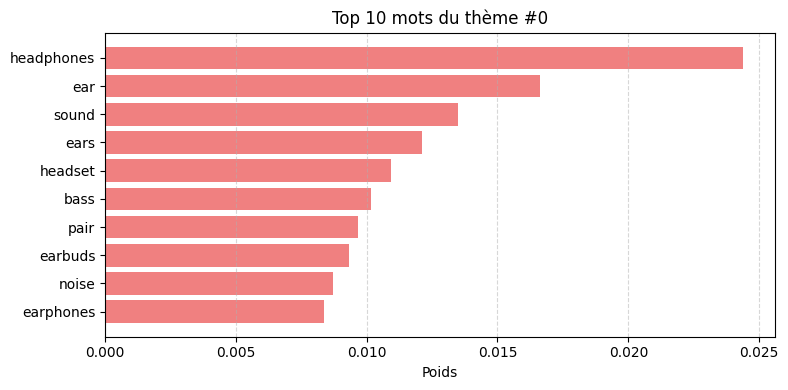

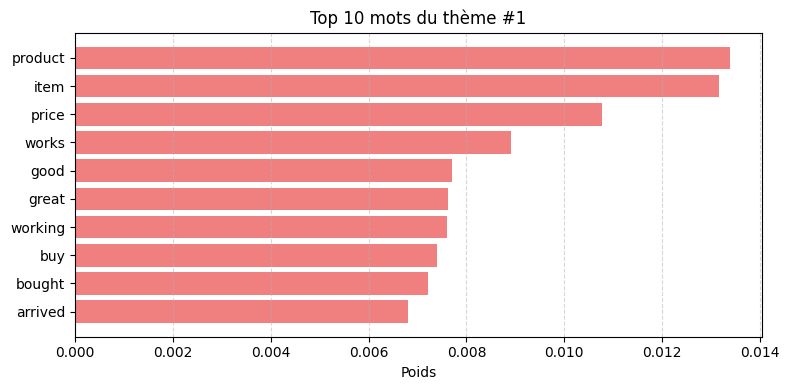

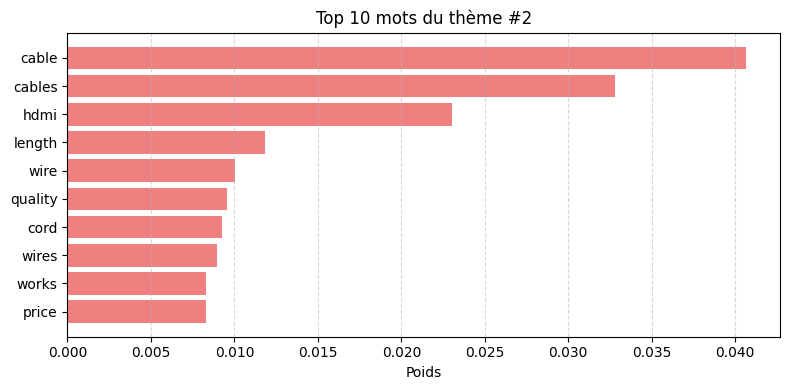

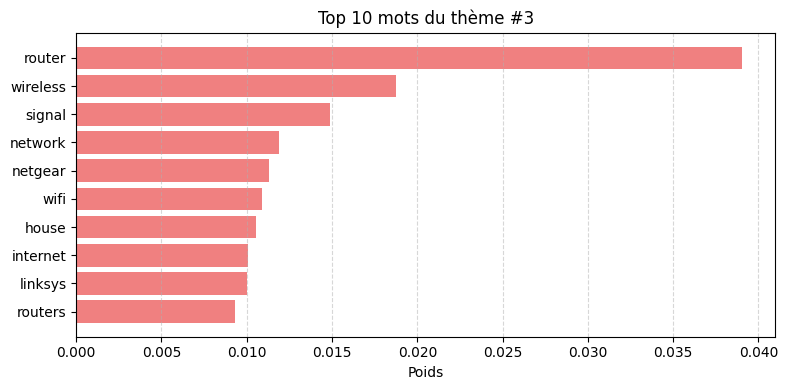

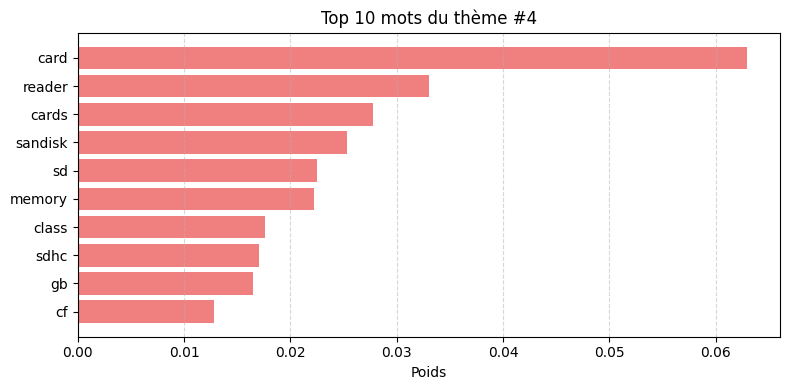

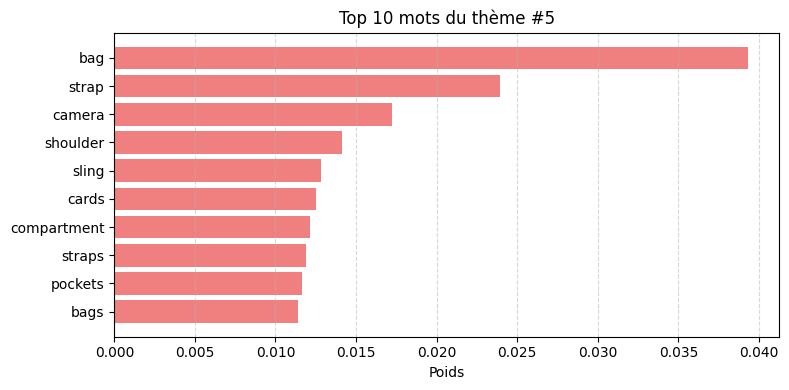

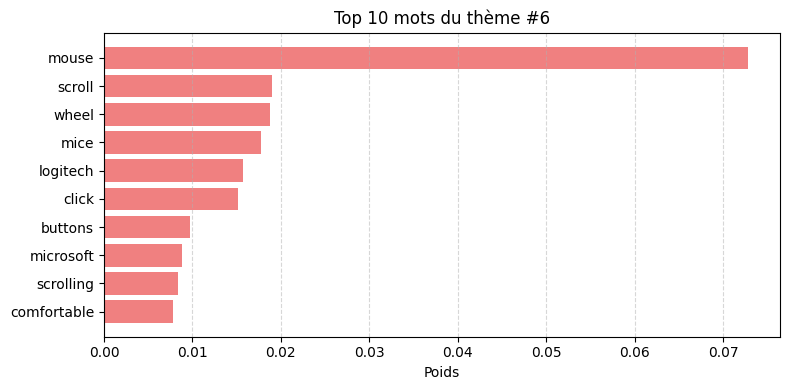

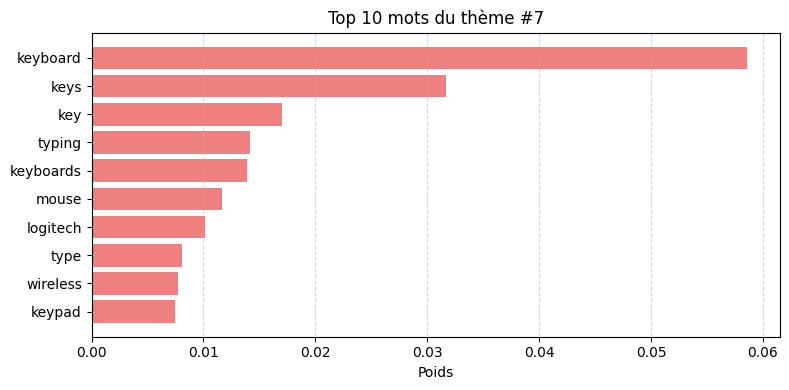

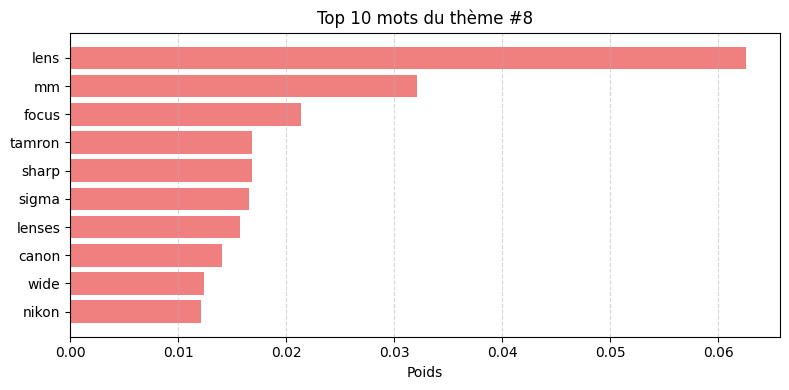

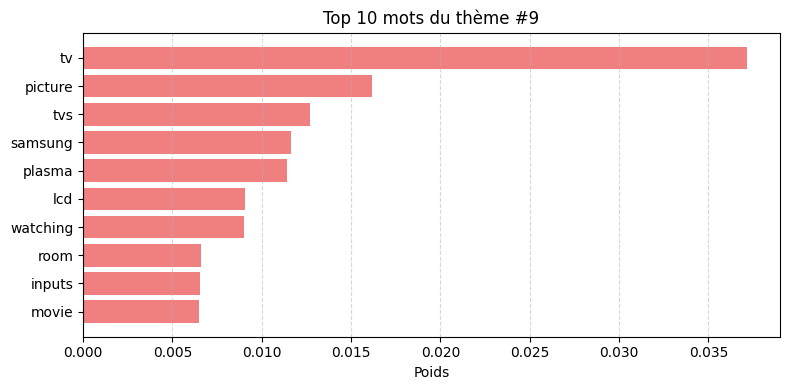

In [ ]:
# Affichage des 10 premiers topics
for i in range(10):
    topic_keywords = topic_model.get_topic(i)
    mots = [mot for mot, _ in topic_keywords]
    scores = [score for _, score in topic_keywords]

    plt.figure(figsize=(8, 4))
    plt.barh(mots[:10][::-1], scores[:10][::-1], color="lightcoral")
    plt.xlabel("Poids")
    plt.title(f"Top 10 mots du thème #{i}")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualisation interactive des thèmes
topic_model.visualize_topics()


In [ ]:
# Evolution temporelle des sujets
df_sample["reviewTime"] = pd.to_datetime(df_sample["reviewTime"])
df_sample = df_sample.reset_index(drop=True)

topics_over_time = topic_model.topics_over_time(
    docs=df_sample["review_clean"],
    topics=topics,
    timestamps=df_sample["reviewTime"],
    nr_bins=20,
    evolution_tuning=True
)

topic_model.visualize_topics_over_time(topics_over_time)


In [ ]:
# On récupére les topics et les probas
df_sample["topic"] = topics
# Pour chaque document, récupérer la proba du topic dominant
df_sample["probability"] = [probs[i][topic] for i, topic in enumerate(topics)]


In [ ]:
# On determine les Themes qui n'étaient pas présents y'a 6 mois avant
df_sample["reviewTime"] = pd.to_datetime(df_sample["reviewTime"])
df_sample["month"] = df_sample["reviewTime"].dt.to_period("M")
# Filtrer les avis récents (dernier mois)
latest_month = df_sample["month"].max()
recent_topics = df_sample[df_sample["month"] == latest_month]["topic"].value_counts()

# Filtrer les avis anciens (6 mois avant)
old_month = latest_month - 6
old_topics = df_sample[df_sample["month"] == old_month]["topic"].value_counts()

# Comparer les tendances
new_topics = set(recent_topics.index) - set(old_topics.index)
print(f"🆕 Nouveaux thèmes apparus ce mois-ci : {new_topics}")


🆕 Nouveaux thèmes apparus ce mois-ci : {128, 132, 138, 139, 141, 147, 148, 149, 153, 32, 162, 41, 48, 69, 197, 71, 203, 77, 89, 220, 102, 105, 122, 124}


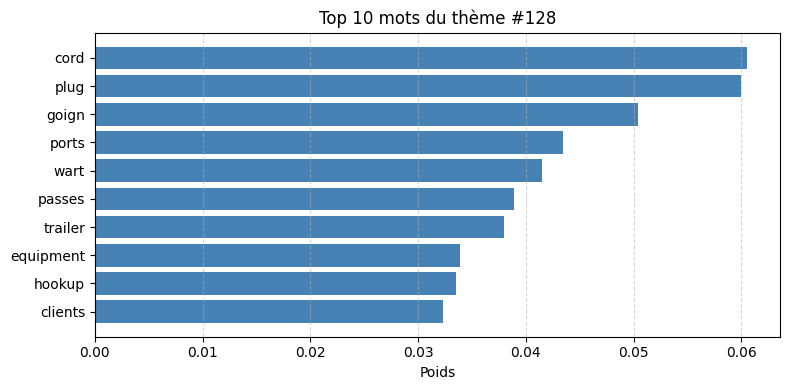

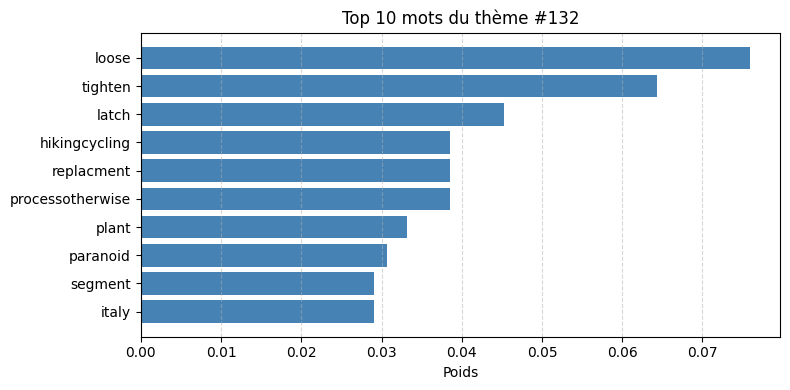

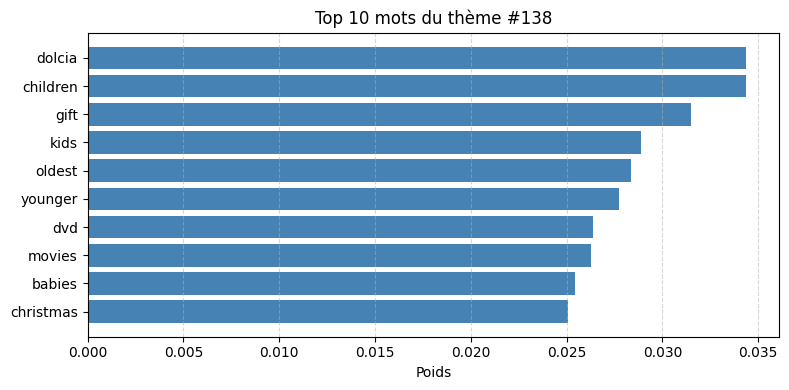

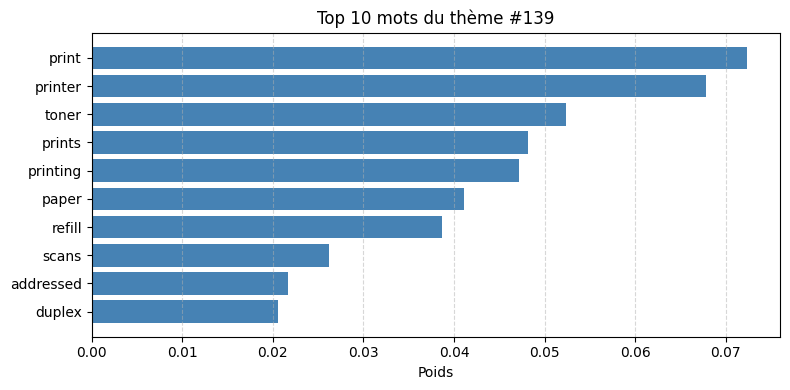

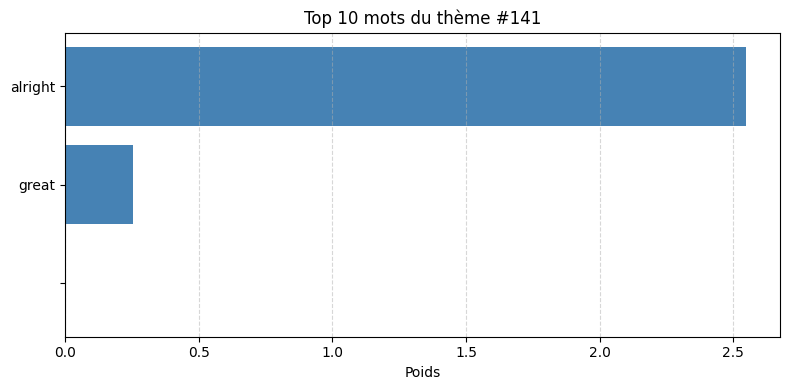

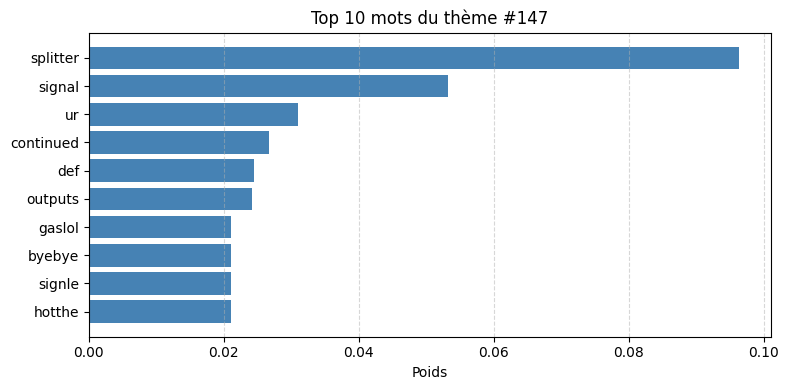

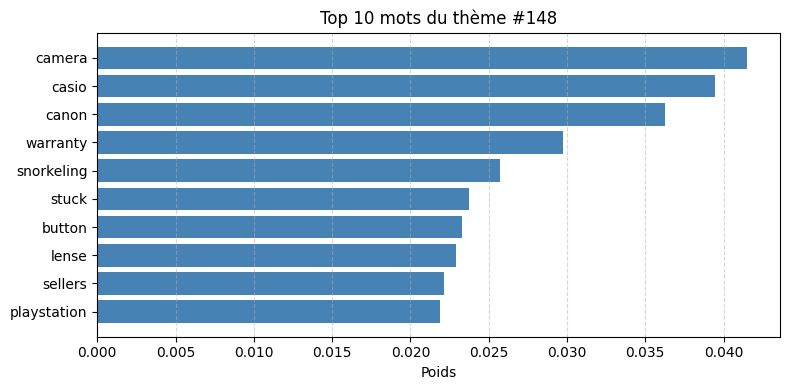

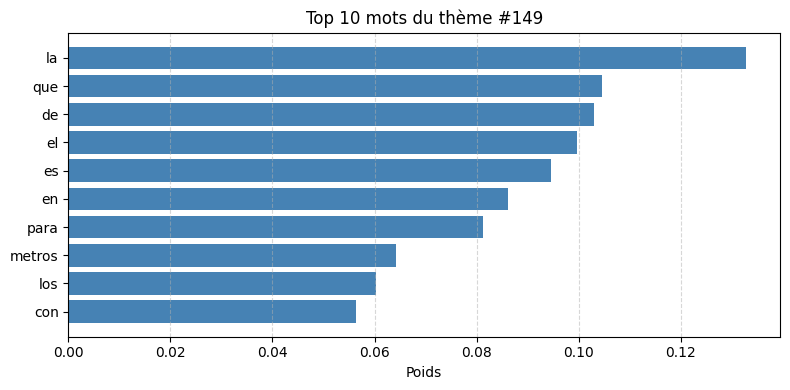

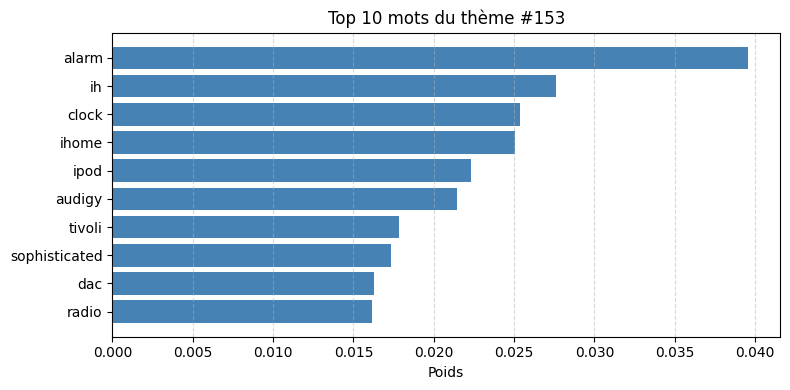

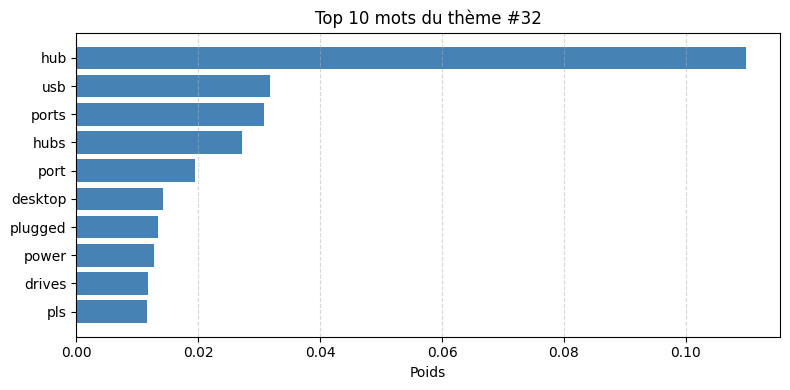

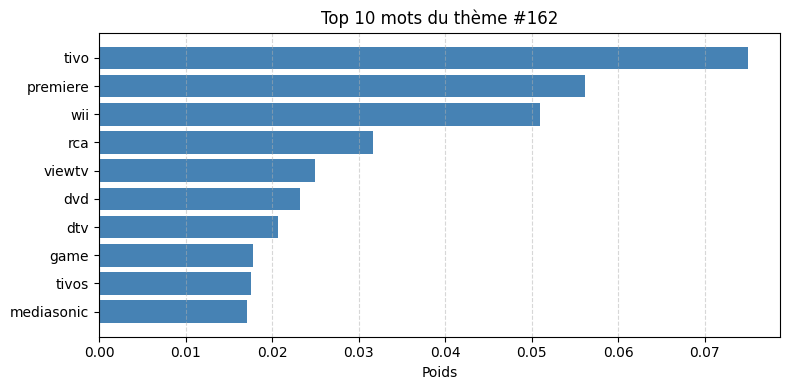

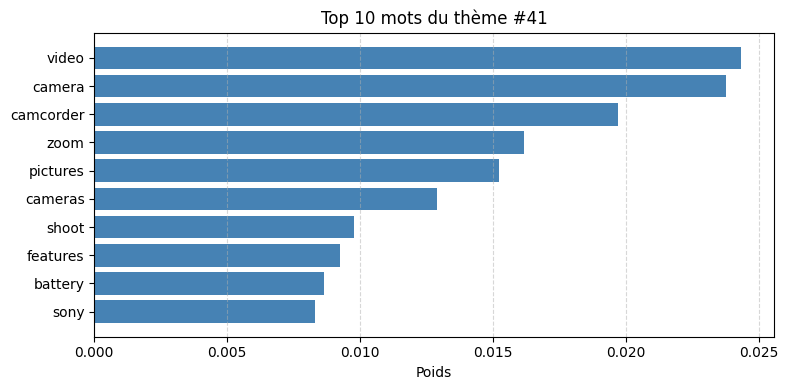

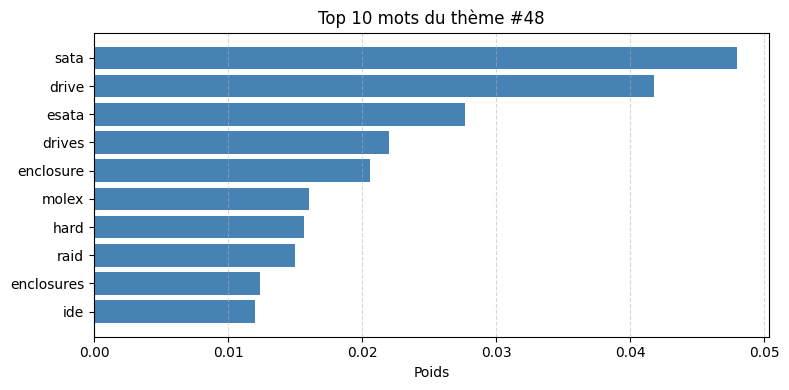

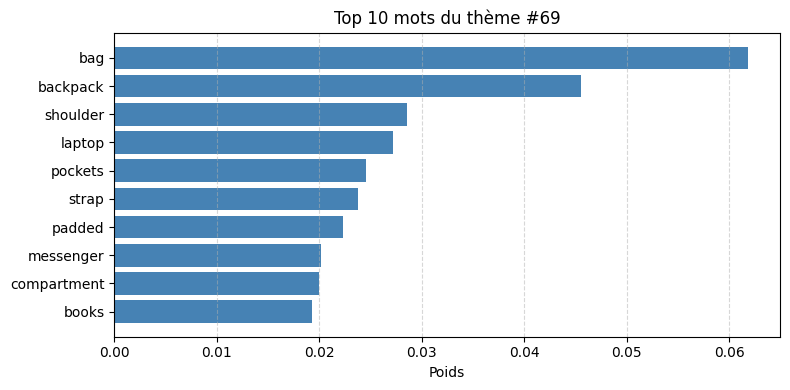

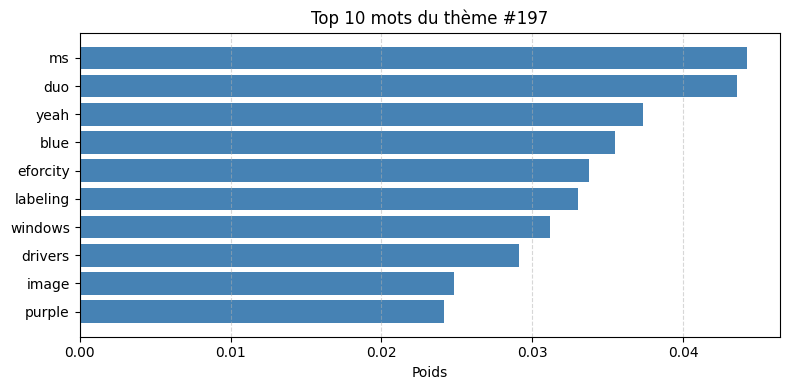

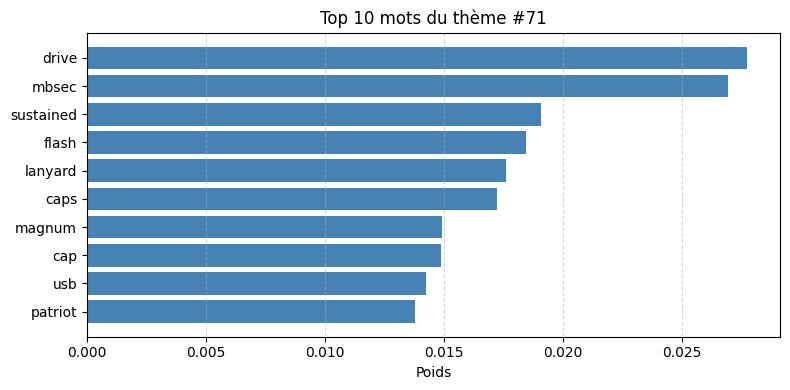

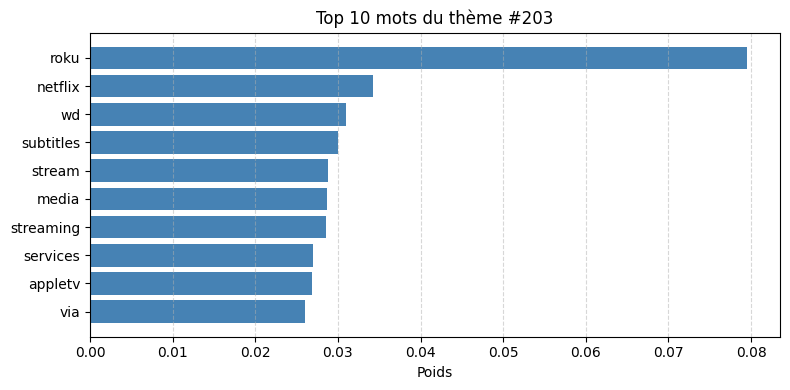

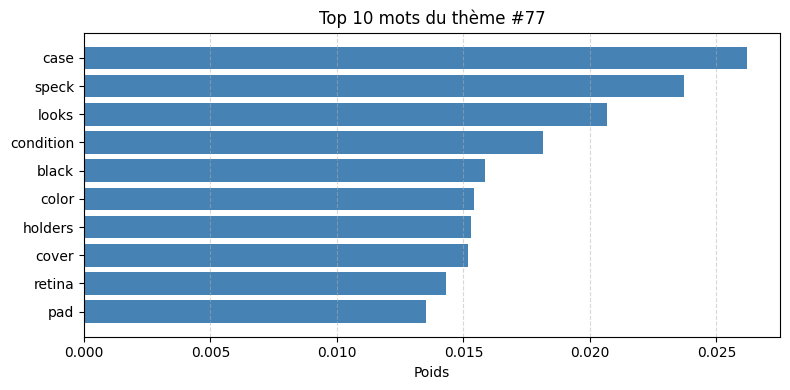

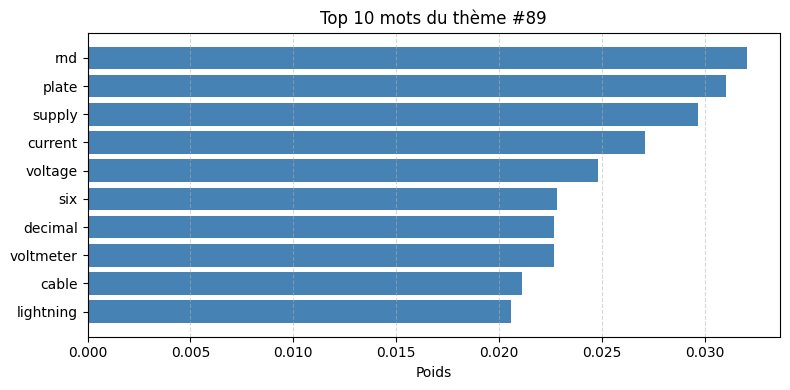

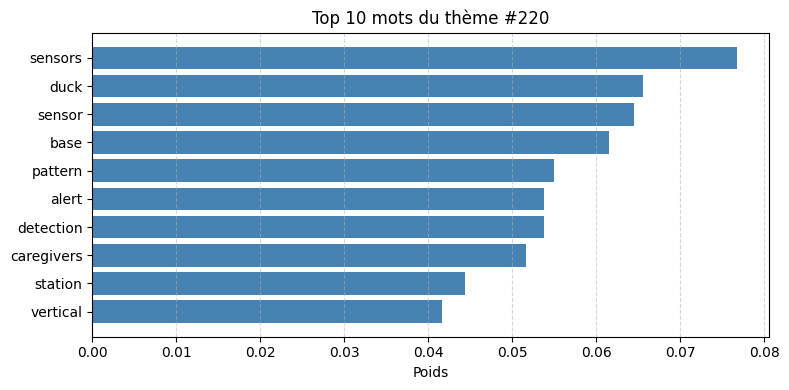

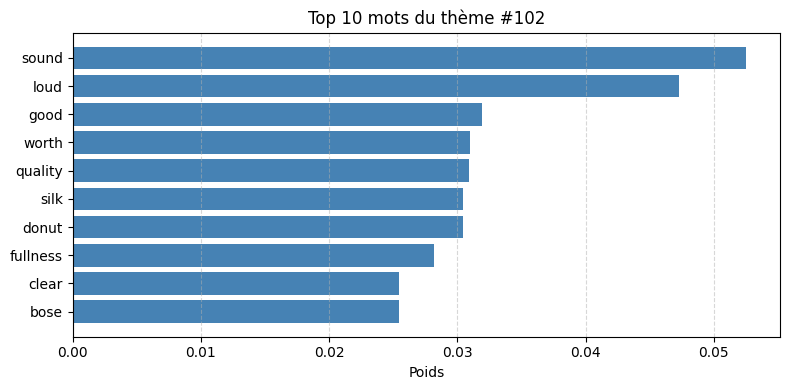

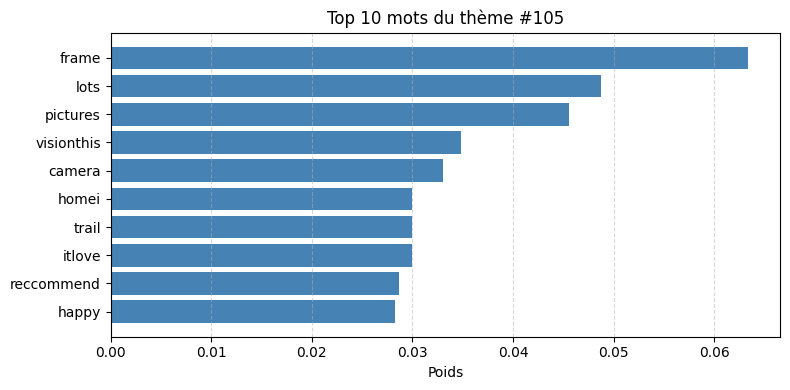

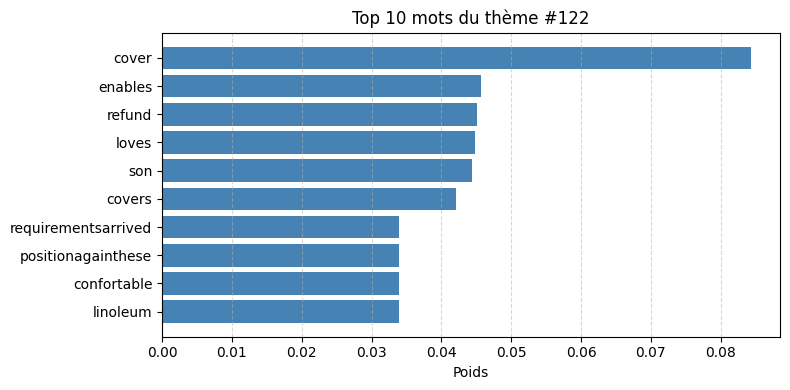

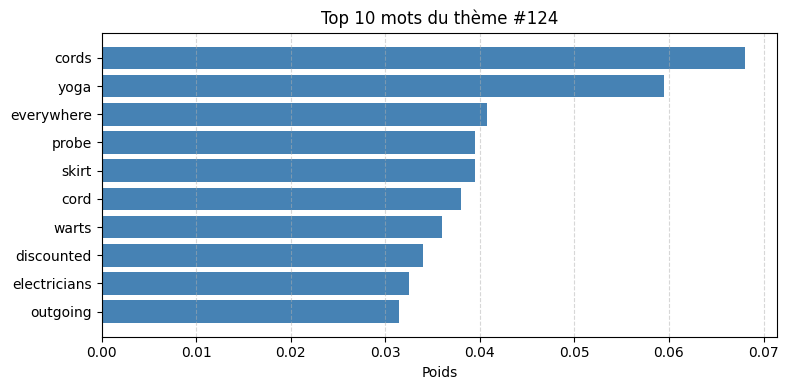

In [ ]:
# Top 10 mots des themes
for topic_id in new_topics:
    # Récupérer les mots et leurs poids
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:  # vérifie que le topic n'est pas vide
        mots = [mot for mot, _ in topic_words][:10]
        scores = [score for _, score in topic_words][:10]

        # Graphique
        plt.figure(figsize=(8, 4))
        plt.barh(mots[::-1], scores[::-1], color="steelblue")
        plt.xlabel("Poids")
        plt.title(f"Top 10 mots du thème #{topic_id}")
        plt.grid(axis="x", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Topic {topic_id} est vide.")


In [ ]:
!pip install -q textblob
from textblob import TextBlob

In [ ]:
from textblob import TextBlob

df_sample["sentiment"] = df_sample["review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
# Calcul de la moyenne des sentiments par topic
sentiments_nouveaux_topics = df_sample[df_sample["topic"].isin(new_topics)] \
    .groupby("topic")["sentiment"] \
    .mean() \
    .reset_index(name="sentiment_moyen") \
    .sort_values(by="sentiment_moyen")

sentiments_nouveaux_topics

,topic,sentiment_moyen
23,220,-0.069486
15,141,0.080000
4,71,0.081806
16,147,0.111967
2,48,0.133045
21,197,0.161205
3,69,0.173830
0,32,0.182684
18,149,0.212014
20,162,0.219232


In [ ]:
def sentiment_label(score):
    if score > 0.1:
        return "positif 🟢"
    elif score < -0.1:
        return "négatif 🔴"
    else:
        return "neutre 🟡"

sentiments_nouveaux_topics["tonalité"] = sentiments_nouveaux_topics["sentiment_moyen"].apply(sentiment_label)
sentiments_nouveaux_topics


,topic,sentiment_moyen,tonalité
23,220,-0.069486,neutre 🟡
15,141,0.080000,neutre 🟡
4,71,0.081806,neutre 🟡
16,147,0.111967,positif 🟢
2,48,0.133045,positif 🟢
21,197,0.161205,positif 🟢
3,69,0.173830,positif 🟢
0,32,0.182684,positif 🟢
18,149,0.212014,positif 🟢
20,162,0.219232,positif 🟢


In [ ]:
df_sample[df_sample["topic"] == 220][["reviewText", "sentiment"]].sample(5)


,reviewText,sentiment
3219,I have owned the Dakota MURS system for 2 year...,-0.010076
6067,Even though its scanner receives quality sign...,-0.500000
6535,Good for normal use. I mean to capture V and U...,0.179167
2134,I have the sensor located about 250 feet from ...,0.053333
3226,This system really works! I've tried several ...,-0.069855


In [ ]:
!pip install -q transformers
!pip install -q torch torchvision torchaudio


In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Pipeline de sentiment
roberta_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [ ]:
# Avis associés aux topics emergents
df_emergents = df_sample[df_sample["topic"].isin(new_topics)].copy()

# Garder seulement ceux qui ont un texte non vide
df_emergents = df_emergents[df_emergents["reviewText"].notnull()]

In [ ]:
# On prend un échantillon de 1000 pour démarrer
sample_emergents = df_emergents.sample(200, random_state=42)

In [ ]:
batch_size = 64

results = []
texts = sample_emergents["reviewText"].dropna().tolist()

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    res = roberta_sentiment(batch, truncation=True, max_length=512)
    results.extend(res)


In [ ]:
labels = [r["label"] for r in results]

# Créer une copie pour travailler
df_roberta = sample_emergents.copy()
df_roberta = df_roberta.iloc[:len(labels)]  # sécuriser l'alignement
df_roberta["sentiment_roberta"] = labels




In [ ]:
sentiment_stats=df_roberta.groupby(["topic", "sentiment_roberta"]).size().unstack(fill_value=0)
sentiment_stats.columns = ["negative", "neutral", "positive"]
sentiment_stats

,negative,neutral,positive
topic,,,
32,4,2,15
41,2,2,14
48,5,6,8
69,3,2,12
71,2,4,5
77,2,0,11
89,2,1,6
102,1,0,5
105,0,0,7


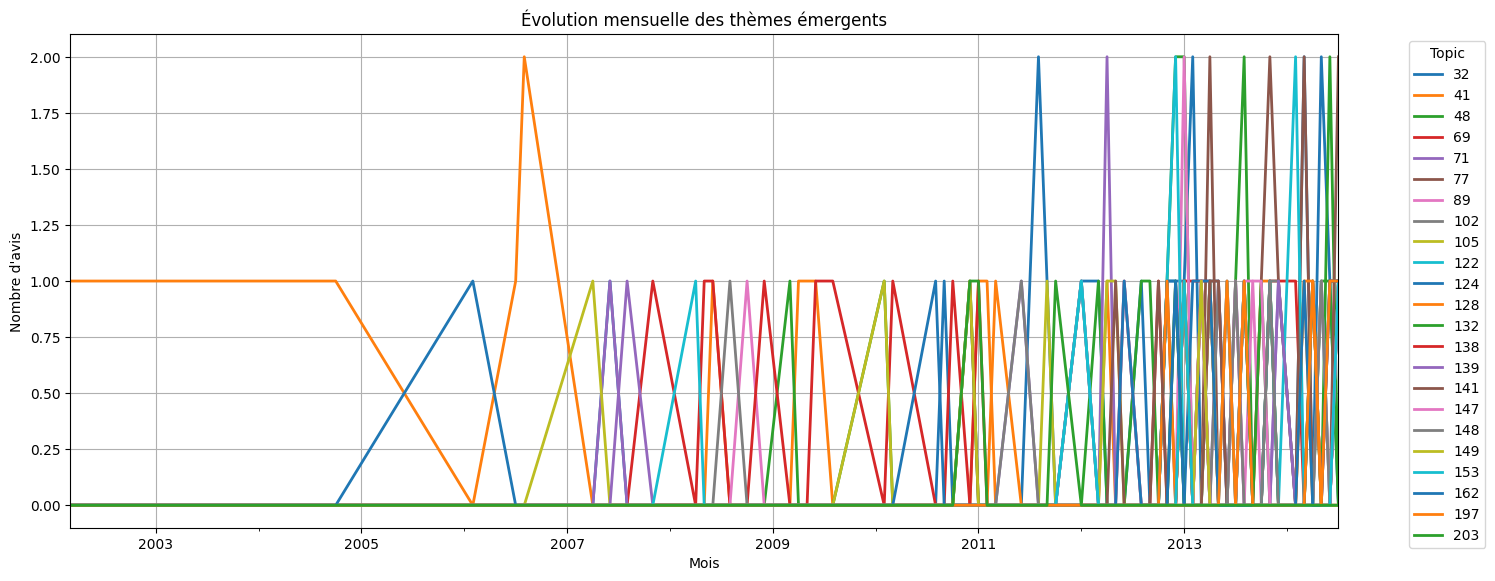

In [ ]:
# L'évolution temporelle des themes emergents
sample_emergents["month"] = sample_emergents["reviewTime"].dt.to_period("M")
topic_time_counts = sample_emergents.groupby(["month", "topic"]).size().unstack(fill_value=0)
topic_time_counts.plot(figsize=(15, 6), linewidth=2)
plt.title("Évolution mensuelle des thèmes émergents")
plt.ylabel("Nombre d'avis")
plt.xlabel("Mois")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


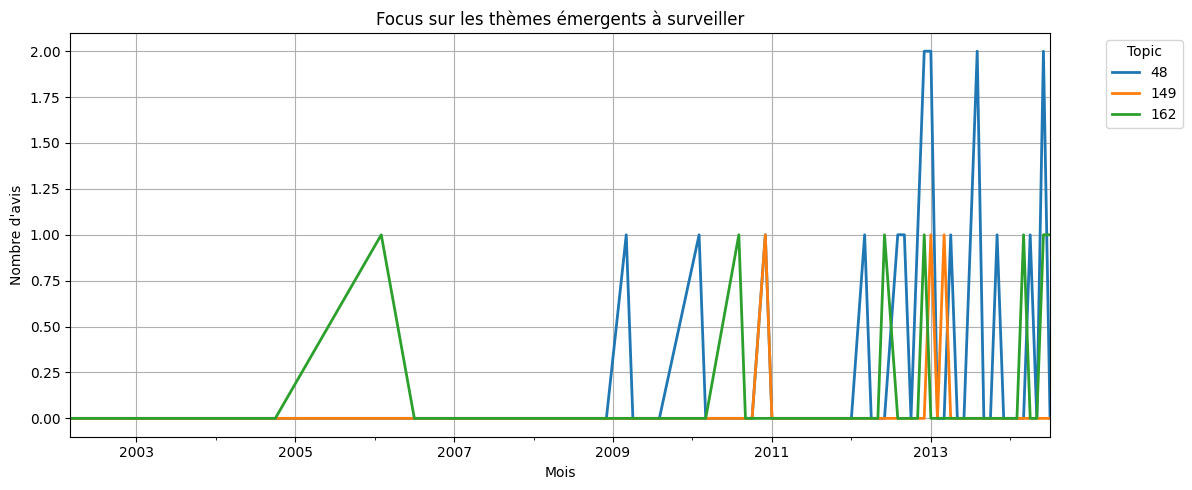

In [ ]:
# Focus sur les plus prooblématiques
topics_to_highlight = [48, 149, 162]  # par exemple
topic_time_counts[topics_to_highlight].plot(figsize=(12, 5), linewidth=2)
plt.title("Focus sur les thèmes émergents à surveiller")
plt.ylabel("Nombre d'avis")
plt.xlabel("Mois")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
